# octConv论文复现
- 原始resnet在tiny-image-net上的实验
- 使用改进卷积octConv的resnet在tiny-image-net上的实验
- 原始densenet在tiny-image-net上的实验
- 使用改进卷积octConv的densenet在tiny-image-net上的实验
- 原始resNext在tiny-image-net上的实验
- 使用改进卷积octConv的resNext在tiny-image-net上的实验

工作说明：
1. 代码编写说明：
    - 论文作者给出了octConv卷积应用于resnet上的实现，然后自己参考实现代码，完成了octConv卷积应用于resnet、densenet和resNeXt网络结构的实现，并使用Ablation Study，对比了这三种网络结构与原网络结构在tiny-image-net分类问题上的用时、准确率等方面的性能差别。
    - 由于课程服务器上的torchvision.models版本落后，没有官方的resNeXt实现，所以自己从官网下载了resNeXt的实现，放到同目录的models.py文件中，除此之外，官方的densenet没有densenet51（为了方便比较，自己将所有网络的层数都设定在50附近），所以自己写了一个densenet51放在densenet.py文件夹下
2. 实验工作说明：
    - 首先自己使用默认的alpha_in=alpha_out=α=0.5作为超参数，在resnet、densenet和resNeXt网络以及其改进网络OctResnet、OctDensenet和OctResNeXt上进行实验，比较他们的性能差异
    - 然后自己在0-1上调整octConv的alpha_in=alpha_out=α参数，如作者指出的那样----从0.125,0.25,0.5,到0.75，对这六个网络进行实验，横向对比baseline model和OctConv model，纵向对比resnet、densenet和resNeXt，并将得出的结果、结论写入报告
    - 原论文在Image net上进行试验，但由于资源限制、时间限制等等，自己仅仅选择了Image net的一个子集----**tiny Image Net**，这个数据集从Image net中选出20个类；其中训练集从Image net选出了10000张，每类500张；测试集从Image net选出了1000张，每类50张


In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import math
import random
import os
import numpy as np
import pandas as pd
from PIL import Image

import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transform
import torchvision.models as models

In [22]:
import torch.nn.functional as F
a = torch.tensor([[1,2,3],[1,2,3],[1,2,3]])
b = torch.tensor([[1,2],[1,2]])
b = F.pad(b, pad = [0, 1, 0, 1], mode='constant', value=0)#对应于左右上下
print(a+b)

tensor([[2, 4, 3],
        [2, 4, 3],
        [1, 2, 3]])


## OctConv卷积实现

In [23]:
class OctConv(nn.Module):

    def __init__(self, in_chanels, out_chanels, kernel_size, alpha_in=0.5, alpha_out=0.5, stride=1, padding=0,
                 groups=1):
        super(OctConv, self).__init__()
        assert (stride == 1 or stride == 2), \
            'please only set stride 1 or 2, because other value lead to complex compute'

        self.down_sample = nn.AvgPool2d(kernel_size=2, stride=2)
        self.up_sample = nn.Upsample(scale_factor=2)
        self.stride = stride
        self.alpha_in = alpha_in
        self.alpha_out = alpha_out

        # 这里只需要根据理论判断各个卷积层是否为None即可，不需要真的考虑alpha_in和alpha_out是不是取到这个值
        # 因为真的要全面考虑会非常复杂
        self.h2h = nn.Conv2d(in_chanels - int(in_chanels * alpha_in), out_chanels - int(out_chanels * alpha_out),
                             kernel_size, padding=padding, groups=groups) if alpha_in != 1 and alpha_out != 1 else None
        self.h2l = nn.Conv2d(in_chanels - int(in_chanels * alpha_in), int(out_chanels * alpha_out),
                             kernel_size, padding=padding, groups=groups) if alpha_in != 1 and alpha_out != 0 else None
        self.l2h = nn.Conv2d(int(in_chanels * alpha_in), out_chanels - int(out_chanels * alpha_out),
                             kernel_size, padding=padding, groups=groups) if alpha_in != 0 and alpha_out != 1 else None
        self.l2l = nn.Conv2d(int(in_chanels * alpha_in), int(out_chanels * alpha_out),
                             kernel_size, padding=padding, groups=groups) if alpha_in != 0 and alpha_out != 0 else None

    def forward(self, x):
        xh, xl = x if type(x) == tuple else (x, None)
        # xh必有，通过h2h，h2l：
        xh = self.down_sample(xh) if self.stride == 2 else xh
        h2h = self.h2h(xh)
        h2l = self.down_sample(self.h2l(xh)) if self.alpha_out != 0 else None

        # 如果有xl，就通过l2h，l2l
        if xl is not None:
            xl = self.up_sample(xl) if self.stride == 1 else xl
            l2h = self.l2h(xl)
            l2l = self.down_sample(self.l2l(xl)) if self.alpha_out != 0 else None
            # 下面的语句后来发现出现了bug，因为h2h是3x3而l2h是2x2，所以如果维度不同要先填充再相加
            # up sample不给力，1x2=2，2x2=4，但是h2h可能分别是3x3，5x5，这时候就不匹配，需要填充0使得2x2->3x3等
            if h2h.shape != l2h.shape:
                l2h = F.pad(l2h, pad = [0, 1, 0, 1], mode='constant', value=0).squeeze(0).squeeze(0)
            return h2h+l2h, (h2l+l2l if self.alpha_out != 0 else None)
        else:
            return h2h, h2l

# 卷积+batch norm
class OctConv_BN(nn.Module):

    def __init__(self, in_chanels, out_chanels, kernel_size, alpha_in=0.5, alpha_out=0.5, stride=1, padding=0,
                 groups=1, norm_layer=nn.BatchNorm2d):
        super(OctConv_BN, self).__init__()
        self.conv = OctConv(in_chanels, out_chanels, kernel_size, alpha_in, alpha_out, stride, padding, groups)
        self.h_bn = norm_layer(out_chanels - int(alpha_out*out_chanels)) if alpha_out != 1 else None
        self.l_bn = norm_layer(int(alpha_out*out_chanels)) if alpha_out != 0 else None

    def forward(self, x):
        xh, xl = self.conv(x)
        xh = self.h_bn(xh) if self.h_bn is not None else None
        xl = self.l_bn(xl) if (self.l_bn is not None and xl is not None) else None
        return xh, xl

# 卷积+batch norm+激活层
class OctConv_BN_ACT(nn.Module):
    def __init__(self, in_chanels, out_chanels, kernel_size, alpha_in=0.5, alpha_out=0.5, stride=1, padding=0,
                 groups=1, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU):
        super(OctConv_BN_ACT, self).__init__()
        self.conv = OctConv(in_chanels, out_chanels, kernel_size, alpha_in, alpha_out, stride, padding, groups)
        self.h_bn = norm_layer(out_chanels - int(alpha_out*out_chanels)) if alpha_out != 1 else None
        self.l_bn = norm_layer(int(alpha_out*out_chanels)) if alpha_out != 0 else None
        self.act = activation_layer(inplace=True)

    def forward(self, x):
        xh, xl = self.conv(x)
        xh = self.act(self.h_bn(xh)) if self.h_bn is not None else None
        xl = self.act(self.l_bn(xl)) if (self.l_bn is not None and xl is not None) else None
        return xh, xl

### 数据集处理&加载
- 原论文在ImageNet上进行实验，本次复现因为资源有限，数据集采用缩小版的ImageNet进行复现，tiny-image-net数据集选自于Imagenet数据集，区别在于它只有20种图片；训练集一共有10000张，每类500张；测试集一共1000张，每类50张
- 数据放在tiny-imagenet-20文件夹下，从该文件夹读取图片，进行数据增广之后转为tensor变量，然后和标签一同返回

In [24]:
filelist = os.listdir('./tiny-imagenet-20/train')

In [25]:
txt_file = open('./tiny-imagenet-20/val/val_annotations.txt').readlines()
val_annotations_mini = open('./tiny-imagenet-20/val/val_annotations_mini.txt', 'w')

for item in txt_file:
    item = item.split()
    if filelist.index(item[1]) < 20:
        val_annotations_mini.write(str(item[0]) + '\t' + str(filelist.index(item[1])) + '\n')
        
val_annotations_mini.close()

In [26]:
class trainDataset(Dataset):

    def __init__(self, root_dir, length, transform):  
        self.root_dir          = root_dir
        self.length            = length
        self.transform         = transform
    
    def __getitem__(self, idx):
        
        image_label = int(idx/500)
        
        filename = filelist[image_label]
        image_id = idx%500
        image = os.path.join(self.root_dir, filename, 'images', filename + '_' + str(image_id) + '.JPEG')
        
        image = Image.open(image).convert('RGB')
        image = self.transform(image)  # preprocessing the image
        
        return image, image_label
    
    def __len__(self):
        # 100000
        return self.length

In [27]:
class valDataset(Dataset):

    def __init__(self, root_dir, length, txt_name, transform):
        self.root_dir          = root_dir
        self.length            = length
        self.txt               = open(os.path.join(self.root_dir, txt_name)).readlines()
        self.transform         = transform
    
    def __getitem__(self, idx):
        
        image_label = int(self.txt[idx].split()[1])
        
        image = os.path.join(self.root_dir, 'images', self.txt[idx].split()[0])
#         print(image_label, image)
        
        image = Image.open(image).convert('RGB')
        image = self.transform(image)  # preprocessing the image
        
        return image, image_label
    
    def __len__(self):
        # 10000
        return self.length

In [28]:
train_transform = transform.Compose([
    transform.Resize(108),
    transform.RandomHorizontalFlip(),
    transform.RandomVerticalFlip(),
    transform.RandomRotation(60), 
    transform.RandomCrop(96, padding=4),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])
val_transform = transform.Compose([
    transform.Resize(96),
    transform.ToTensor(),
    transform.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])

train_dataset = trainDataset(
    root_dir='./tiny-imagenet-20/train',
    length=10000,
    transform=train_transform)
val_dataset = valDataset(
    root_dir='./tiny-imagenet-20/val',
    length=1000,
    txt_name='val_annotations_mini.txt',
    transform=val_transform)

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=256,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=256,
    shuffle=False
)

### 训练与测试

In [29]:
def train(model, train_loader, loss_func, optimizer, device):
    total_loss = 0
    correct = 0
    total_size = 0
    for i, (images, targets) in enumerate(train_loader):
        images = images.to(device)
        targets = targets.to(device)
        
        outputs = model(images)
        loss = loss_func(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_size = total_size + targets.size(0)
        
        _, predict = torch.max(outputs, dim=1)
        correct = correct + (predict==targets).sum().item()
    
    accuracy = 100 * correct/total_size
    
    print('loss on train set: {}'.format(total_loss/len(train_loader)))
    print('accuracy on train Set: {:.4f} %'.format(accuracy))
            
    return total_loss/len(train_loader), accuracy

In [30]:
def evaluate(model, val_loader, loss_func, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        total_loss = 0
        total_size = 0
        for i, (images, targets) in enumerate(val_loader):
            images = images.to(device)
            targets = targets.to(device)

            outputs = model(images)
            _, predict = torch.max(outputs, dim=1)
            correct = correct + (predict==targets).sum().item()
            
            loss = loss_func(outputs, targets)
            total_loss += loss.item()
            total_size = total_size + targets.size(0)
                
        accuracy = 100 * correct/total_size
        
        print('Loss on val set: {}'.format(total_loss/len(val_loader)))
        print('Accuracy on val Set: {:.4f} %'.format(accuracy))
        
        return total_loss/len(val_loader), accuracy

In [31]:
import datetime

def fit(model, num_epochs, optimizer, device, lr):
    loss_func = nn.CrossEntropyLoss()
    
    model.to(device)
    loss_func.to(device)
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    
    start = datetime.datetime.now()
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch+1, num_epochs))
        train_loss, train_acc = train(model, train_loader, loss_func, optimizer, device)
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        
        val_loss, val_acc = evaluate(model, val_loader, loss_func, device)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
        
        if (epoch + 1) % 20 == 0:
            lr = lr/2
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr
        
        print('execute time until now:', (datetime.datetime.now()-start).seconds)
        
    return (train_losses, train_accs, val_losses, val_accs, (datetime.datetime.now()-start).seconds)

In [32]:
import matplotlib.pyplot as plt
def show_curve(ys1, ys2, title):
    x = np.array(range(len(ys1)))
    y1 = np.array(ys1)
    y2 = np.array(ys2)
    plt.axis()
    plt.plot(x, y1, c = 'b')
    plt.plot(x, y2, c = 'g')
    plt.title(title+' curve, blue for trainset, green for valset')
    plt.xlabel('epoch')
    plt.ylabel(title)
    plt.show()

## 使用普通resnet进行训练

In [13]:
device = torch.device('cuda:0')
resnet50 = models.resnet50(pretrained=False)

num_input = resnet50.fc.in_features
resnet50.avgpool = nn.AvgPool2d(kernel_size=3, stride=1, padding=0)
resnet50.fc = nn.Sequential(
#     nn.Dropout(0.3),
    nn.Linear(num_input, 20)
)

In [14]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(resnet50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(resnet50, num_epochs, optimizer, device, lr)

Epoch 1/40:
loss on train set: 1.5523517435523355
accuracy on train Set: 26.6646 %
Loss on val set: 1.5131821185350418
Accuracy on val Set: 32.2490 %
execute time until now: 37
Epoch 2/40:
loss on train set: 1.4886261126038376
accuracy on train Set: 29.7153 %
Loss on val set: 1.4637748077511787
Accuracy on val Set: 30.9839 %
execute time until now: 78
Epoch 3/40:
loss on train set: 1.4176006689193144
accuracy on train Set: 35.8050 %
Loss on val set: 1.4180804044008255
Accuracy on val Set: 34.6410 %
execute time until now: 120
Epoch 4/40:
loss on train set: 1.3691753794433206
accuracy on train Set: 39.3446 %
Loss on val set: 1.345143549144268
Accuracy on val Set: 42.6615 %
execute time until now: 161
Epoch 5/40:
loss on train set: 1.3338328630301604
accuracy on train Set: 42.1189 %
Loss on val set: 1.3099276572465897
Accuracy on val Set: 45.2769 %
execute time until now: 205
Epoch 6/40:
loss on train set: 1.3118229709613096
accuracy on train Set: 44.0795 %
Loss on val set: 1.31835726648

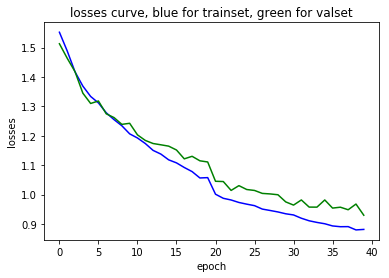

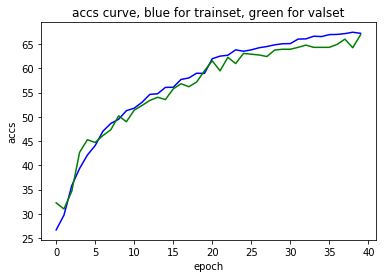

In [15]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

## 使用octConv卷积的resnet进行训练
此处自己的代码修正了官方pytorch OctResNet实现的问题:alpha_in=alpha_out=α可以自定义，官方代码即使设置了α，在某些oct卷积层alpha仍然是默认的0.5；除此之外，此处的代码将高低频层的合并放到最后一个卷积来实现，而官方的代码在最后一个BottleNeck的第一个卷积就把高低频分量合并了。

In [17]:
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_chanels, planes, alpha_in=0.5, alpha_out=0.5, stride=1, norm_layer=nn.BatchNorm2d,
                 activation_layer=nn.ReLU, down_sample=None, is_first_bottle=False, is_last_bottle=False):
        super(BottleNeck, self).__init__()
        # 如果这个bottleneck是该网络的第一个，那么alpha_in设置为0
        self.conv1 = OctConv_BN_ACT(in_chanels, planes, kernel_size=1, alpha_in=alpha_in if not is_first_bottle else 0,
                                    alpha_out=alpha_out, norm_layer=norm_layer, activation_layer=activation_layer)
        self.conv2 = OctConv_BN_ACT(planes, planes, kernel_size=3, padding=1, alpha_in=alpha_in, alpha_out=alpha_out,
                                    stride=stride,
                                    norm_layer=norm_layer, activation_layer=activation_layer)
        # 如果这个bottleneck是该网络的最后一个，那么alpha_out设置为0
        self.conv3 = OctConv_BN(planes, planes * self.expansion, kernel_size=1, alpha_in=alpha_in,
                                alpha_out=alpha_out if not is_last_bottle else 0, norm_layer=norm_layer)
        # 如果这个bottleneck是每一个layer的第一个，那么就要down_sample ori_x，保证维度一致，能够相加输入和输出
        self.down_sample = down_sample
        self.is_last_bottle = is_last_bottle
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        xh, xl = self.conv1(x)
        xh, xl = self.conv2((xh, xl))
        xh, xl = self.conv3((xh, xl))

        # 如果经过bottleneck之后输入和输出不能匹配，就使用down_sample把维度统一
        origin_high, origin_low = x if type(x) == tuple else (x, None)
        if self.down_sample is not None:
            origin_high, origin_low = self.down_sample(x)

        # 这里是resnet的关键的，即将bottleneck输出与输入相加
        # 如果这个bottleneck是该网络的最后一个，那么xh和origin_high（xh只有一半chanel）会不匹配，此时需要特别处理
        xh = (xh + origin_high) if not self.is_last_bottle else xh
        xl = xl + origin_low if (origin_low is not None and xl is not None) else None
        
        # 激活函数在合并之前执行，这就是为什么conv3是OctConv_BN而不是OctConv_BN_ACT
        xh = self.relu(xh)
        xl = self.relu(xl) if xl is not None else None

        return xh, xl


# 此处的octresnet仿照pytorch的resnet进行实现，参数基本一致，多出来的alpha_in=alpha_out用于调整octConv的高低频分量
class OctResNet(nn.Module):

    def __init__(self, block, layers, num_classes=20, alpha_in=0.5, alpha_out=0.5, norm_layer=nn.BatchNorm2d):
        super(OctResNet, self).__init__()
        self.norm_layer = norm_layer
        self.in_planes = 64
        self.alpha_in = alpha_in
        self.alpha_out = alpha_out

        # 第一个卷积层不使用octconv，因为输入的三个通道没有“高低频的含义”，仅仅表示颜色通道而已
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3)
        self.bn = norm_layer(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 此后的卷积均采用octconv，其中第一个octconv使用is_input表示输入alpha_in=0
        self.layer1 = self.make_layer(block, 64, layers[0], is_input=True)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        # 最后一个octconv使用is_output表示alpha_out=0
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2, is_output=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, planes, blocks, stride=1, is_input=False, is_output=False):
        norm_layer = self.norm_layer
        down_sample = None
        # 判断输出和输入维度是否一致，如果不是，就要down_sample到一致，同时注意该卷积是不是第一个卷积
        if stride != 1 or self.in_planes != planes * block.expansion:
            down_sample = nn.Sequential(
                OctConv_BN(self.in_planes, planes * block.expansion, kernel_size=1,
                           alpha_in=self.alpha_in if not is_input else 0, alpha_out=self.alpha_out, stride=stride,
                           norm_layer=norm_layer)
            )
        layer = []
        # 注意该卷积是不是第一个卷积
        layer.append(
            block(self.in_planes, planes, alpha_in=self.alpha_in, alpha_out=self.alpha_out,
                  stride=stride, down_sample=down_sample, norm_layer=norm_layer, is_first_bottle=is_input))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            # 注意该卷积是不是最后一个卷积，判断方法为is_output and i == blocks - 1
            layer.append(
                block(self.in_planes, planes, alpha_in=self.alpha_in, alpha_out=self.alpha_out,
                      norm_layer=norm_layer, is_last_bottle=(is_output and i == blocks - 1)))
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        xh, xl = self.layer1(x)
        xh, xl = self.layer2((xh, xl))
        xh, xl = self.layer3((xh, xl))
        x, _ = self.layer4((xh, xl))

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [19]:
OctResnet50 = OctResNet(BottleNeck, [3, 4, 6, 3], num_classes=20, alpha_in=0.25, alpha_out=0.25)
device = torch.device('cuda:3')

In [20]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(OctResnet50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(OctResnet50, num_epochs, optimizer, device, lr)

Epoch 1/40:


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


loss on train set: 1.466496715120449
accuracy on train Set: 30.2985 %
Loss on val set: 1.4223219826817513
Accuracy on val Set: 40.8656 %
execute time until now: 174
Epoch 2/40:
loss on train set: 1.390206554892716
accuracy on train Set: 37.6829 %
Loss on val set: 1.3553324043750763
Accuracy on val Set: 40.0000 %
execute time until now: 336
Epoch 3/40:
loss on train set: 1.3237496713164505
accuracy on train Set: 42.9884 %
Loss on val set: 1.3182275742292404
Accuracy on val Set: 41.5933 %
execute time until now: 492
Epoch 4/40:
loss on train set: 1.2810637715515818
accuracy on train Set: 46.1303 %
Loss on val set: 1.2486361935734749
Accuracy on val Set: 48.6826 %
execute time until now: 648
Epoch 5/40:
loss on train set: 1.2490143532965594
accuracy on train Set: 48.4458 %
Loss on val set: 1.2336438596248627
Accuracy on val Set: 50.4975 %
execute time until now: 816
Epoch 6/40:
loss on train set: 1.2216576451708556
accuracy on train Set: 49.9199 %
Loss on val set: 1.1956223100423813
Accur

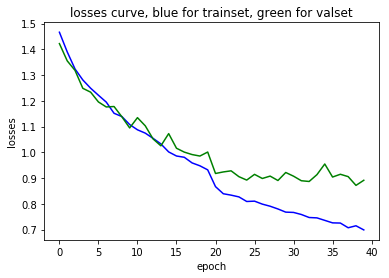

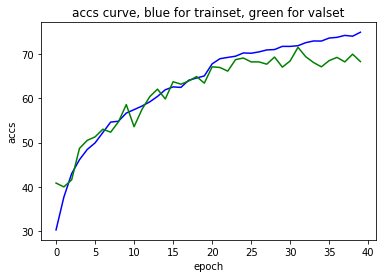

In [21]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

In [47]:
OctResnet50 = OctResNet(BottleNeck, [3, 4, 6, 3], num_classes=20, alpha_in=0.5, alpha_out=0.5)
device = torch.device('cuda:1')

In [48]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(OctResnet50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(OctResnet50, num_epochs, optimizer, device, lr)

Epoch 1/40:
loss on train set: 1.4535965668927333
accuracy on train Set: 32.9697 %
Loss on val set: 1.396771565079689
Accuracy on val Set: 41.5933 %
execute time until now: 103
Epoch 2/40:
loss on train set: 1.3762548683555262
accuracy on train Set: 38.9487 %
Loss on val set: 1.3308593034744263
Accuracy on val Set: 43.7035 %
execute time until now: 209
Epoch 3/40:
loss on train set: 1.3175757888016428
accuracy on train Set: 43.6807 %
Loss on val set: 1.341989815235138
Accuracy on val Set: 41.7133 %
execute time until now: 316
Epoch 4/40:
loss on train set: 1.2747847168308915
accuracy on train Set: 46.2709 %
Loss on val set: 1.2467131465673447
Accuracy on val Set: 47.6445 %
execute time until now: 424
Epoch 5/40:
loss on train set: 1.2421744424066725
accuracy on train Set: 48.2286 %
Loss on val set: 1.2173960655927658
Accuracy on val Set: 49.3964 %
execute time until now: 531
Epoch 6/40:
loss on train set: 1.209295822556611
accuracy on train Set: 50.9215 %
Loss on val set: 1.22313868254

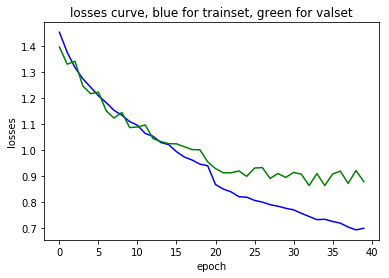

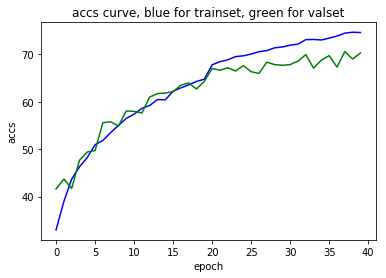

In [49]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

In [18]:
OctResnet50 = OctResNet(BottleNeck, [3, 4, 6, 3], num_classes=20, alpha_in=0.75, alpha_out=0.75)
device = torch.device('cuda:3')

In [19]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(OctResnet50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(OctResnet50, num_epochs, optimizer, device, lr)

Epoch 1/40:


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


loss on train set: 1.4906059384346009
accuracy on train Set: 24.3105 %
Loss on val set: 1.4969367682933807
Accuracy on val Set: 20.9762 %
execute time until now: 129
Epoch 2/40:
loss on train set: 1.4742824852466583
accuracy on train Set: 29.9333 %
Loss on val set: 1.4490159153938293
Accuracy on val Set: 33.4664 %
execute time until now: 259
Epoch 3/40:
loss on train set: 1.4339484810829162
accuracy on train Set: 36.4829 %
Loss on val set: 1.4007896482944489
Accuracy on val Set: 39.4968 %
execute time until now: 389
Epoch 4/40:
loss on train set: 1.3805995762348175
accuracy on train Set: 39.7869 %
Loss on val set: 1.3582265377044678
Accuracy on val Set: 42.3084 %
execute time until now: 518
Epoch 5/40:
loss on train set: 1.3220943361520767
accuracy on train Set: 42.4264 %
Loss on val set: 1.3129630088806152
Accuracy on val Set: 42.8952 %
execute time until now: 646
Epoch 6/40:
loss on train set: 1.2972536027431487
accuracy on train Set: 44.6990 %
Loss on val set: 1.30510675907135
Accur

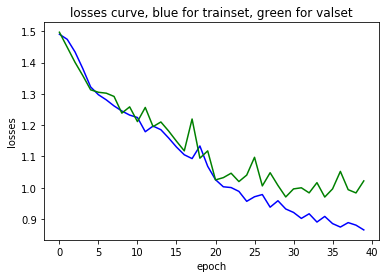

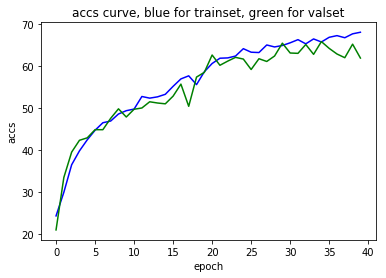

In [20]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

## 原始densenet在tiny-image-net上的实验

In [30]:
from densenet import create_densenet

device = torch.device('cuda:1')
_densenet51 = create_densenet('densenet51', 32, (3, 4, 10, 6), 64)

num_input = _densenet51.classifier.in_features
_densenet51.linear = nn.Sequential(
#     nn.Dropout(0.3),
    nn.Linear(num_input, 20)
)

In [31]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(_densenet51.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(_densenet51, num_epochs, optimizer, device, lr)

Epoch 1/40:
loss on train set: 2.560144722082053
accuracy on train Set: 30.3809 %
Loss on val set: 1.7620800510048866
Accuracy on val Set: 37.5500 %
execute time until now: 29
Epoch 2/40:
loss on train set: 1.3346159716320645
accuracy on train Set: 44.1814 %
Loss on val set: 1.2725005224347115
Accuracy on val Set: 46.9042 %
execute time until now: 64
Epoch 3/40:
loss on train set: 1.242699465174584
accuracy on train Set: 49.2544 %
Loss on val set: 1.2125352546572685
Accuracy on val Set: 51.3809 %
execute time until now: 103
Epoch 4/40:
loss on train set: 1.1921331620520088
accuracy on train Set: 52.3450 %
Loss on val set: 1.1974786594510078
Accuracy on val Set: 52.2494 %
execute time until now: 138
Epoch 5/40:
loss on train set: 1.1656553707305033
accuracy on train Set: 54.0740 %
Loss on val set: 1.1407987624406815
Accuracy on val Set: 55.6776 %
execute time until now: 174
Epoch 6/40:
loss on train set: 1.1159808225692458
accuracy on train Set: 57.0964 %
Loss on val set: 1.137901321053

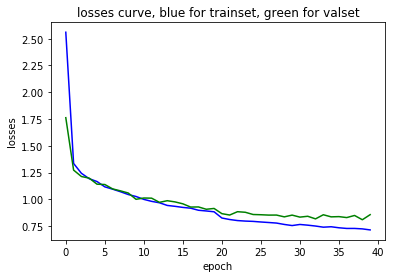

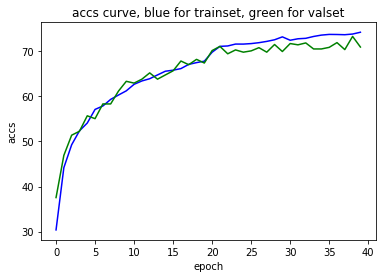

In [32]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

## 使用改进卷积octConv的densenet在tiny-image-net上的实验

In [14]:
from collections import OrderedDict

#具体的Dense层
class _DenseLayer(nn.Sequential):
    def __init__(self, num_input_features, growth_rate, bn_size, alpha_in, alpha_out):
        super(_DenseLayer, self).__init__()
        self.conv1 = OctConv_BN_ACT(in_chanels=num_input_features, out_chanels=bn_size * growth_rate, kernel_size=1,
                                    alpha_in=alpha_in, alpha_out=alpha_out)
        self.conv2 = OctConv_BN(in_chanels=bn_size * growth_rate, out_chanels=growth_rate, kernel_size=3, stride=1,
                                padding=1, alpha_in=alpha_in, alpha_out=alpha_out)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        (orixh, orixl) = x
        xh, xl = self.conv1(x)
        xh, xl = self.conv2((xh, xl))
        # densenet的关键，即将输入和输入concatenate起来
        # 由于tensor被分成高低频两个分量，所以需要分别合并两个分量
        xh = self.relu(torch.cat((orixh, xh), 1))
        xl = self.relu(torch.cat((orixl, xl), 1))
        return xh, xl

# block块，包含多个层
class _DenseBlock(nn.Sequential):
    def __init__(self, num_layers, num_input_features, bn_size, growth_rate, alpha_in, alpha_out):
        super(_DenseBlock, self).__init__()
        for i in range(num_layers):
            layer = _DenseLayer(num_input_features + i * growth_rate, growth_rate, bn_size, alpha_in=alpha_in,
                                alpha_out=alpha_out)
            self.add_module('denselayer%d' % (i + 1), layer)


class _Transition(nn.Sequential):
    def __init__(self, num_input_features, num_output_features, alpha_in, alpha_out):
        super(_Transition, self).__init__()
        self.conv = OctConv_BN_ACT(in_chanels=num_input_features, out_chanels=num_output_features, kernel_size=1,
                                   stride=1, alpha_in=alpha_in, alpha_out=alpha_out)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        xh, xl = self.conv(x)
        # 两个高低频分量分别做池化（直接池化self.conv(x)会报错，不能池化tuple(xh,xl)！）
        xh = self.pool(xh)
        xl = self.pool(xl)
        return xh, xl


class OctDenseNet(nn.Module):

    def __init__(self, growth_rate=32, bn_size=4, block_config=(6, 12, 24, 16), num_classes=20, alpha_in=0.5,
                 alpha_out=0.5):
        super(OctDenseNet, self).__init__()
        num_features = 64
        self.features = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(3, num_features, kernel_size=7, stride=2, padding=3, bias=False)),
            ('norm0', nn.BatchNorm2d(num_features)),
            ('relu0', nn.ReLU(inplace=True)),
            ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
        ]))

        # 经过前面OctResNet的编写，自己发现其实只需要在开始和结尾处使得alpha_in和alpha_out分别为0即可
        # 省去很多复杂情况的考虑，所以下面这里是新增的、原始densenet实现没有的一个层，用来把一个层分成高低频分量
        self.features.add_module('first_oct_conv',
                                 OctConv_BN_ACT(in_chanels=num_features, out_chanels=num_features, kernel_size=1,
                                                alpha_in=0, alpha_out=alpha_out))

        for i, num_layers in enumerate(block_config):
            block = _DenseBlock(num_layers=num_layers, num_input_features=num_features, bn_size=bn_size,
                                growth_rate=growth_rate, alpha_in=alpha_in, alpha_out=alpha_out)
            self.features.add_module('denseblock%d' % (i + 1), block)
            num_features = num_features + num_layers * growth_rate
            if i != len(block_config) - 1:
                trans = _Transition(num_input_features=num_features, num_output_features=num_features // 2,
                                    alpha_in=alpha_in, alpha_out=alpha_out)
                self.features.add_module('transition%d' % (i + 1), trans)
                num_features = num_features // 2

        # 最后一个卷积层，这里是新增的、原始densenet实现没有的一个层，用来把前面输出的两个高低频分量合为一个
        # 设置alpha_out=0即可，这样才能够进行后续的全局池化、线性层
        self.features.add_module('final_oct_conv',
                                 OctConv_BN_ACT(in_chanels=num_features, out_chanels=num_features, kernel_size=1,
                                                alpha_in=alpha_in, alpha_out=0))

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        out, _ = self.features(x)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [17]:
octDenseNet51 = OctDenseNet(growth_rate=32, block_config=(3, 4, 10, 6), num_classes=20, alpha_in=0.25, alpha_out=0.25)
device = torch.device('cuda:3')

In [18]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(octDenseNet51.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(octDenseNet51, num_epochs, optimizer, device, lr)

Epoch 1/40:


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


loss on train set: 1.4535960452571797
accuracy on train Set: 33.7935 %
Loss on val set: 1.3983832821249962
Accuracy on val Set: 43.5890 %
execute time until now: 249
Epoch 2/40:
loss on train set: 1.3483516281577432
accuracy on train Set: 41.9881 %
Loss on val set: 1.2956941053271294
Accuracy on val Set: 46.7974 %
execute time until now: 412
Epoch 3/40:
loss on train set: 1.2800081041967792
accuracy on train Set: 45.5961 %
Loss on val set: 1.2433514147996902
Accuracy on val Set: 48.9898 %
execute time until now: 585
Epoch 4/40:
loss on train set: 1.248576859000382
accuracy on train Set: 48.3839 %
Loss on val set: 1.2425124570727348
Accuracy on val Set: 47.7493 %
execute time until now: 773
Epoch 5/40:
loss on train set: 1.2074055853922656
accuracy on train Set: 50.7445 %
Loss on val set: 1.162491150200367
Accuracy on val Set: 55.5878 %
execute time until now: 950
Epoch 6/40:
loss on train set: 1.1756494728622922
accuracy on train Set: 52.5071 %
Loss on val set: 1.12895193323493
Accurac

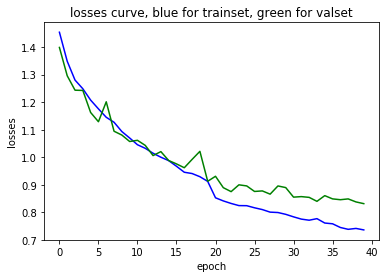

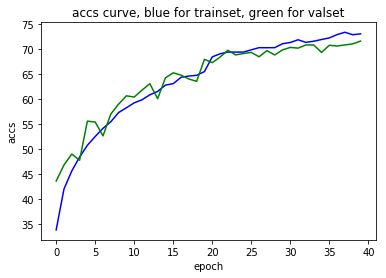

In [19]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

In [38]:
octDenseNet51 = OctDenseNet(growth_rate=32, block_config=(3, 4, 10, 6), num_classes=20)
device = torch.device('cuda:1')

In [39]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(octDenseNet51.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(octDenseNet51, num_epochs, optimizer, device, lr)

Epoch 1/40:
loss on train set: 1.458556267106609
accuracy on train Set: 34.2491 %
Loss on val set: 1.398199275135994
Accuracy on val Set: 39.6232 %
execute time until now: 115
Epoch 2/40:
loss on train set: 1.364941429939999
accuracy on train Set: 40.7554 %
Loss on val set: 1.3308250457048416
Accuracy on val Set: 43.2435 %
execute time until now: 234
Epoch 3/40:
loss on train set: 1.2961406039584213
accuracy on train Set: 45.2327 %
Loss on val set: 1.2739878073334694
Accuracy on val Set: 47.0106 %
execute time until now: 352
Epoch 4/40:
loss on train set: 1.2457731392732851
accuracy on train Set: 49.3052 %
Loss on val set: 1.2165734320878983
Accuracy on val Set: 49.8999 %
execute time until now: 470
Epoch 5/40:
loss on train set: 1.200733274411244
accuracy on train Set: 51.2055 %
Loss on val set: 1.1748275458812714
Accuracy on val Set: 52.3450 %
execute time until now: 588
Epoch 6/40:
loss on train set: 1.1742887728533167
accuracy on train Set: 52.4976 %
Loss on val set: 1.164544478058

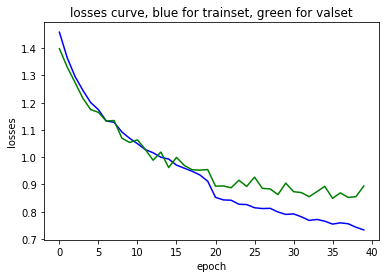

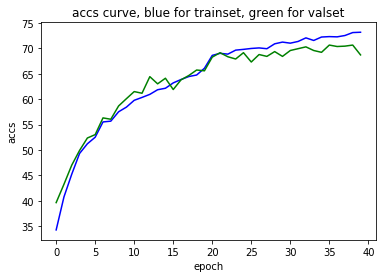

In [40]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

In [15]:
octDenseNet51 = OctDenseNet(growth_rate=32, block_config=(3, 4, 10, 6), num_classes=20, alpha_in=0.75, alpha_out=0.75)
device = torch.device('cuda:3')

In [16]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(octDenseNet51.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(octDenseNet51, num_epochs, optimizer, device, lr)

Epoch 1/40:


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


loss on train set: 1.4803981691598893
accuracy on train Set: 30.6268 %
Loss on val set: 1.4932516515254974
Accuracy on val Set: 25.4951 %
execute time until now: 68
Epoch 2/40:
loss on train set: 1.4644227385520936
accuracy on train Set: 32.5115 %
Loss on val set: 1.429913491010666
Accuracy on val Set: 33.9116 %
execute time until now: 137
Epoch 3/40:
loss on train set: 1.4125484079122543
accuracy on train Set: 36.1248 %
Loss on val set: 1.3886605501174927
Accuracy on val Set: 36.7423 %
execute time until now: 207
Epoch 4/40:
loss on train set: 1.3722435891628266
accuracy on train Set: 39.4715 %
Loss on val set: 1.3561448156833649
Accuracy on val Set: 38.3406 %
execute time until now: 277
Epoch 5/40:
loss on train set: 1.3306143254041671
accuracy on train Set: 42.1189 %
Loss on val set: 1.3199263513088226
Accuracy on val Set: 43.2435 %
execute time until now: 348
Epoch 6/40:
loss on train set: 1.2990281254053115
accuracy on train Set: 45.2990 %
Loss on val set: 1.3417018055915833
Accur

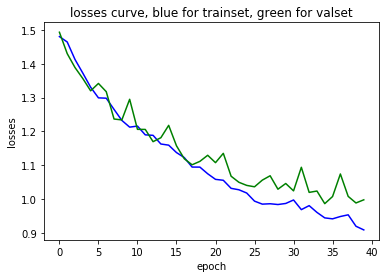

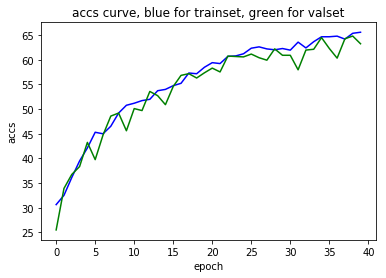

In [17]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

## 使用原始resNext在tiny-image-net上的实验

In [14]:
from models import *

In [15]:
device = torch.device('cuda:1')
resnext50 = resnext50_32x4d(pretrained=False)

num_input = resnext50.fc.in_features
resnext50.avgpool = nn.AvgPool2d(kernel_size=3, stride=1, padding=0)
resnext50.fc = nn.Sequential(
#     nn.Dropout(0.3),
    nn.Linear(num_input, 20)
)

In [16]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(resnext50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(resnext50, num_epochs, optimizer, device, lr)

Epoch 1/40:
loss on train set: 1.5165292829464956
accuracy on train Set: 27.1477 %
Loss on val set: 1.4821318238973618
Accuracy on val Set: 29.8329 %
execute time until now: 71
Epoch 2/40:
loss on train set: 1.4877591763332392
accuracy on train Set: 31.0322 %
Loss on val set: 1.4336901307106018
Accuracy on val Set: 36.4692 %
execute time until now: 144
Epoch 3/40:
loss on train set: 1.3983145177743996
accuracy on train Set: 37.0405 %
Loss on val set: 1.4164399430155754
Accuracy on val Set: 40.7431 %
execute time until now: 221
Epoch 4/40:
loss on train set: 1.3556568197384002
accuracy on train Set: 40.7799 %
Loss on val set: 1.3562026247382164
Accuracy on val Set: 39.6232 %
execute time until now: 298
Epoch 5/40:
loss on train set: 1.3323420901207408
accuracy on train Set: 43.1161 %
Loss on val set: 1.3020753860473633
Accuracy on val Set: 44.7214 %
execute time until now: 371
Epoch 6/40:
loss on train set: 1.3016838511084294
accuracy on train Set: 45.0999 %
Loss on val set: 1.322531536

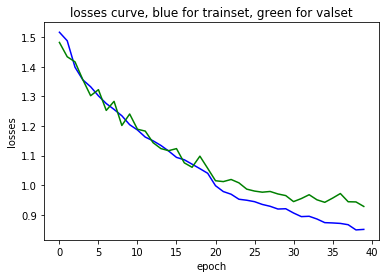

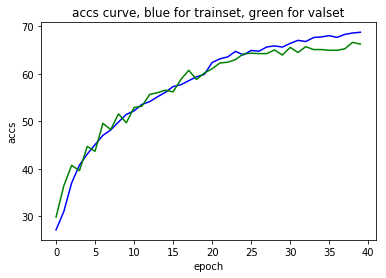

In [17]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

## 使用改进卷积octConv的resNext在tiny-image-net上的实验

In [10]:
# resNeXt和resNet的不同之处仅在于分组group，所以只需要微小的改变，加入group、width_per_group即可
class BottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_chanels, planes, alpha_in=0.5, alpha_out=0.5, stride=1, norm_layer=nn.BatchNorm2d,
                 activation_layer=nn.ReLU, down_sample=None, is_first_bottle=False, is_last_bottle=False, groups=1,
                 width_per_group=64):
        super(BottleNeck, self).__init__()
        width = int(planes * (width_per_group / 64)) * groups
        # 如果这个bottleneck是该网络的第一个，那么alpha_in设置为0
        self.conv1 = OctConv_BN_ACT(in_chanels, width, kernel_size=1, alpha_in=alpha_in if not is_first_bottle else 0,
                                    alpha_out=alpha_out, norm_layer=norm_layer, activation_layer=activation_layer)
        self.conv2 = OctConv_BN_ACT(width, width, kernel_size=3, padding=1, alpha_in=alpha_in, alpha_out=alpha_out,
                                    stride=stride, groups=groups,
                                    norm_layer=norm_layer, activation_layer=activation_layer)
        # 如果这个bottleneck是该网络的最后一个，那么alpha_out设置为0
        self.conv3 = OctConv_BN(width, planes * self.expansion, kernel_size=1, alpha_in=alpha_in,
                                alpha_out=alpha_out if not is_last_bottle else 0, norm_layer=norm_layer)
        # 如果这个bottleneck是每一个layer的第一个，那么就要down_sample ori_x，保证维度一致，能够相加输入和输出
        self.down_sample = down_sample
        self.is_last_bottle = is_last_bottle
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        xh, xl = self.conv1(x)
        xh, xl = self.conv2((xh, xl))
        xh, xl = self.conv3((xh, xl))

        # 如果经过bottleneck之后输入和输出不能匹配，就使用down_sample把维度统一
        origin_high, origin_low = x if type(x) == tuple else (x, None)
        if self.down_sample is not None:
            origin_high, origin_low = self.down_sample(x)

        # 如果这个bottleneck是该网络的最后一个，那么xh和origin_high（xh只有一半chanel）会不匹配，此时需要特别处理
        xh = (xh + origin_high) if not self.is_last_bottle else xh
        xl = xl + origin_low if (origin_low is not None and xl is not None) else None

        # 激活函数在合并之前执行，这就是为什么conv3是OctConv_BN而不是OctConv_BN_ACT
        xh = self.relu(xh)
        xl = self.relu(xl) if xl is not None else None

        return xh, xl


# 此处的octresnet仿照pytorch的resnet进行实现，参数基本一致，多出来的alpha_in=alpha_out用于调整octConv的高低频分量
class OctResNeXt(nn.Module):

    def __init__(self, block, layers, num_classes=20, alpha_in=0.5, alpha_out=0.5, norm_layer=nn.BatchNorm2d, groups=1,
                 width_per_group=64):
        super(OctResNeXt, self).__init__()
        self.norm_layer = norm_layer
        self.in_planes = 64
        self.alpha_in = alpha_in
        self.alpha_out = alpha_out
        self.groups = groups
        self.width_per_group = width_per_group

        # 第一个卷积层不使用octconv，因为输入的三个通道没有“高低频的含义”，仅仅表示颜色通道而已
        self.conv1 = nn.Conv2d(3, self.in_planes, kernel_size=7, stride=2, padding=3)
        self.bn = norm_layer(self.in_planes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        # 此后的卷积均采用octconv，其中第一个octconv使用is_input表示输入alpha_in=0
        self.layer1 = self.make_layer(block, 64, layers[0], is_input=True)
        self.layer2 = self.make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.make_layer(block, 256, layers[2], stride=2)
        # 最后一个octconv使用is_output表示alpha_out=0
        self.layer4 = self.make_layer(block, 512, layers[3], stride=2, is_output=True)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def make_layer(self, block, planes, blocks, stride=1, is_input=False, is_output=False):
        norm_layer = self.norm_layer
        down_sample = None
        # 判断输出和输入维度是否一致，如果不是，就要down_sample到一致，同时注意该卷积是不是第一个卷积
        if stride != 1 or self.in_planes != planes * block.expansion:
            down_sample = nn.Sequential(
                OctConv_BN(self.in_planes, planes * block.expansion, kernel_size=1,
                           alpha_in=self.alpha_in if not is_input else 0, alpha_out=self.alpha_out, stride=stride,
                           norm_layer=norm_layer)
            )
        layer = []
        # 注意该卷积是不是第一个卷积
        layer.append(
            block(self.in_planes, planes, alpha_in=self.alpha_in, alpha_out=self.alpha_out, groups=self.groups,
                  width_per_group=self.width_per_group, stride=stride, down_sample=down_sample, norm_layer=norm_layer,
                  is_first_bottle=is_input))
        self.in_planes = planes * block.expansion
        for i in range(1, blocks):
            # 注意该卷积是不是最后一个卷积，判断方法为is_output and i == blocks - 1
            layer.append(
                block(self.in_planes, planes, alpha_in=self.alpha_in, alpha_out=self.alpha_out, groups=self.groups,
                      width_per_group=self.width_per_group, norm_layer=norm_layer,
                      is_last_bottle=(is_output and i == blocks - 1)))
        return nn.Sequential(*layer)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        xh, xl = self.layer1(x)
        xh, xl = self.layer2((xh, xl))
        xh, xl = self.layer3((xh, xl))
        x, _ = self.layer4((xh, xl))

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [17]:
OctResnext50 = OctResNeXt(BottleNeck, [3, 4, 6, 3], width_per_group=4, groups=32, num_classes=20, alpha_in=0.25, alpha_out=0.25)
device = torch.device('cuda:3')

In [18]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(OctResnext50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(OctResnext50, num_epochs, optimizer, device, lr)

Epoch 1/40:


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


loss on train set: 1.4732577679263559
accuracy on train Set: 28.4605 %
Loss on val set: 1.4516200348734856
Accuracy on val Set: 34.9285 %
execute time until now: 277
Epoch 2/40:
loss on train set: 1.413401615088153
accuracy on train Set: 36.8103 %
Loss on val set: 1.384629800915718
Accuracy on val Set: 36.8782 %
execute time until now: 538
Epoch 3/40:
loss on train set: 1.334962749936778
accuracy on train Set: 41.7612 %
Loss on val set: 1.3214445486664772
Accuracy on val Set: 43.3590 %
execute time until now: 802
Epoch 4/40:
loss on train set: 1.291089050329415
accuracy on train Set: 45.3542 %
Loss on val set: 1.2801295667886734
Accuracy on val Set: 46.2601 %
execute time until now: 1084
Epoch 5/40:
loss on train set: 1.2570918282126164
accuracy on train Set: 47.3603 %
Loss on val set: 1.2244767546653748
Accuracy on val Set: 49.0918 %
execute time until now: 1360
Epoch 6/40:
loss on train set: 1.2286175724807058
accuracy on train Set: 49.9300 %
Loss on val set: 1.2181312590837479
Accur

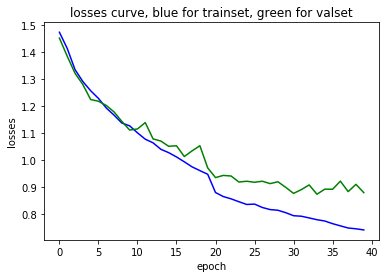

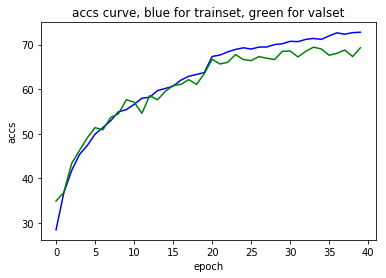

In [19]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

In [48]:
OctResnext50 = OctResNeXt(BottleNeck, [3, 4, 6, 3], width_per_group=4, groups=32, num_classes=20)
device = torch.device('cuda:1')

In [49]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(OctResnext50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(OctResnext50, num_epochs, optimizer, device, lr)

Epoch 1/40:
loss on train set: 1.4777411040227124
accuracy on train Set: 28.7576 %
Loss on val set: 1.4476726725697517
Accuracy on val Set: 35.3553 %
execute time until now: 313
Epoch 2/40:
loss on train set: 1.4193467091602885
accuracy on train Set: 36.0139 %
Loss on val set: 1.3495175912976265
Accuracy on val Set: 41.1096 %
execute time until now: 626
Epoch 3/40:
loss on train set: 1.341294732822734
accuracy on train Set: 40.6817 %
Loss on val set: 1.3388782143592834
Accuracy on val Set: 42.4264 %
execute time until now: 934
Epoch 4/40:
loss on train set: 1.3114748251665929
accuracy on train Set: 43.6692 %
Loss on val set: 1.2852619215846062
Accuracy on val Set: 45.6070 %
execute time until now: 1208
Epoch 5/40:
loss on train set: 1.2695209084043078
accuracy on train Set: 46.6798 %
Loss on val set: 1.2549141645431519
Accuracy on val Set: 46.9042 %
execute time until now: 1536
Epoch 6/40:
loss on train set: 1.2456617104779384
accuracy on train Set: 48.0208 %
Loss on val set: 1.2426547

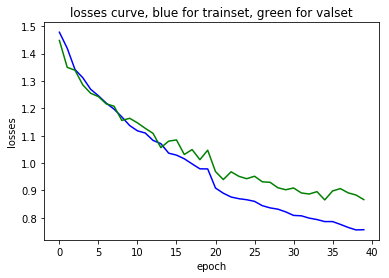

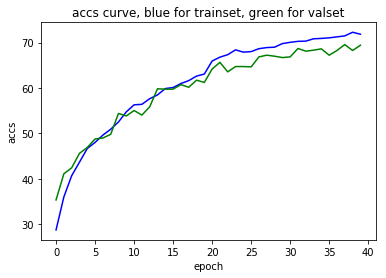

In [50]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')

In [17]:
OctResnext50 = OctResNeXt(BottleNeck, [3, 4, 6, 3], width_per_group=4, groups=32, num_classes=20, alpha_in=0.75, alpha_out=0.75)
device = torch.device('cuda:3')

In [18]:
num_epochs = 40
lr = 0.001

optimizer = torch.optim.SGD(OctResnext50.parameters(), lr=lr, momentum=0.9)
train_losses, train_accs, val_losses, val_accs, times = fit(OctResnext50, num_epochs, optimizer, device, lr)

Epoch 1/40:


/opt/conda/lib/python3.6/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


loss on train set: 1.490090900659561
accuracy on train Set: 24.2074 %
Loss on val set: 1.497637689113617
Accuracy on val Set: 23.0217 %
execute time until now: 181
Epoch 2/40:
loss on train set: 1.4930142790079117
accuracy on train Set: 25.4165 %
Loss on val set: 1.4807913601398468
Accuracy on val Set: 27.9285 %
execute time until now: 364
Epoch 3/40:
loss on train set: 1.4740338802337647
accuracy on train Set: 31.3847 %
Loss on val set: 1.4528827965259552
Accuracy on val Set: 34.2053 %
execute time until now: 546
Epoch 4/40:
loss on train set: 1.4404163926839828
accuracy on train Set: 36.5240 %
Loss on val set: 1.4256244897842407
Accuracy on val Set: 37.0135 %
execute time until now: 729
Epoch 5/40:
loss on train set: 1.3907507061958313
accuracy on train Set: 39.3827 %
Loss on val set: 1.3646134436130524
Accuracy on val Set: 43.3590 %
execute time until now: 911
Epoch 6/40:
loss on train set: 1.3435421288013458
accuracy on train Set: 42.3438 %
Loss on val set: 1.335872858762741
Accura

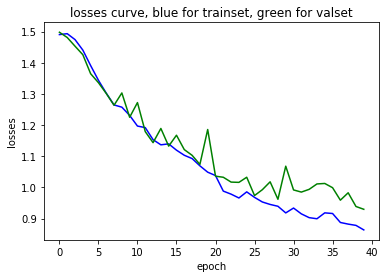

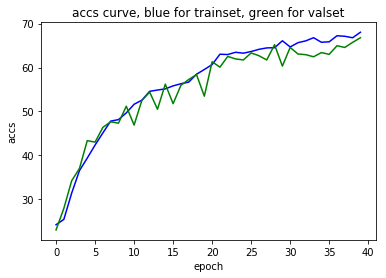

In [19]:
show_curve(train_losses, val_losses, 'losses')
show_curve(train_accs, val_accs, 'accs')